# 3-Layer Neural Network for Non-linear Regression (TensorFlow with Built-in Layers)
In this notebook, we implement a 3-layer neural network using TensorFlow's built-in layers via the Keras Sequential API.
While we leverage high-level layer abstractions for simplicity, we’ll still write a custom training loop to retain full control over the optimization process—striking a balance between ease of use and flexibility.

To ensure consistency and comparability, we’ll train the model on the same synthetic 3-variable non-linear dataset used in our previous implementations.

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the function to generate synthetic data
def true_function(X):
    """
    Non-linear function with 3 variables
    X should be a matrix with 3 columns
    """
    return 2 * tf.math.sin(X[:, 0]) + 3 * tf.math.cos(X[:, 1]) + 0.5 * X[:, 2]**2 + 0.1 * X[:, 0] * X[:, 1] * X[:, 2]

# Generate synthetic dataset
def generate_data(n_samples=1000):
    # Generate random inputs
    X = tf.cast(tf.random.uniform((n_samples, 3), -2, 2), tf.float32)

    # Calculate true output values
    y_true = true_function(X)

    # Add some noise
    y = y_true + tf.random.normal((n_samples,), 0, 0.5)

    return X, tf.reshape(y, (-1, 1))

# Generate training data
X_train, y_train = generate_data(1000)

# Generate test data
X_test, y_test = generate_data(200)

print(f"Training data shape: X = {X_train.shape}, y = {y_train.shape}")
print(f"Test data shape: X = {X_test.shape}, y = {y_test.shape}")

Training data shape: X = (1000, 3), y = (1000, 1)
Test data shape: X = (200, 3), y = (200, 1)


## Neural Network Implementation with TensorFlow Built-in Layers
In this section, we’ll construct a 3-layer neural network using TensorFlow’s built-in layers through the Keras Sequential API.
To maintain flexibility and insight into the training process, we’ll pair this with a custom training loop using tf.GradientTape.

This approach offers:

Simplicity in model definition using Dense layers

Full control over training steps, loss computation, and parameter updates

A balance between high-level abstraction and low-level customization

In [2]:
# Create model using Keras layers
def create_model(input_size, hidden1_size, hidden2_size, output_size):
    # Initialize Keras Sequential model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden1_size, activation='relu', input_shape=(input_size,),
                             kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.Dense(hidden2_size, activation='relu',
                             kernel_initializer=tf.keras.initializers.HeNormal()),
        tf.keras.layers.Dense(output_size, activation=None,
                             kernel_initializer=tf.keras.initializers.HeNormal())
    ])

    return model

# Create model instance
input_size = 3
hidden1_size = 10
hidden2_size = 5
output_size = 1

model = create_model(input_size, hidden1_size, hidden2_size, output_size)
model.summary()

# Define loss function
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Define the training step using gradient tape
@tf.function
def train_step(model, X, y, optimizer):
    with tf.GradientTape() as tape:
        # Forward pass
        y_pred = model(X, training=True)

        # Compute loss
        loss = mse_loss(y, y_pred)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

# Create optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Training loop
num_epochs = 3000
batch_size = 64
print_interval = 100
losses = []

# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    # Train on batches
    for X_batch, y_batch in train_dataset:
        batch_loss = train_step(model, X_batch, y_batch, optimizer)
        epoch_loss += batch_loss
        num_batches += 1

    # Average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Print progress
    if epoch % print_interval == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.6f}")

    # Store loss value
    if epoch % 10 == 0:
        losses.append(avg_loss.numpy())

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 0/3000, Loss: 8.484500
Epoch 100/3000, Loss: 0.289888
Epoch 200/3000, Loss: 0.267719
Epoch 300/3000, Loss: 0.256313
Epoch 400/3000, Loss: 0.248185
Epoch 500/3000, Loss: 0.245254
Epoch 600/3000, Loss: 0.244541
Epoch 700/3000, Loss: 0.250253
Epoch 800/3000, Loss: 0.246080
Epoch 900/3000, Loss: 0.244285
Epoch 1000/3000, Loss: 0.245076
Epoch 1100/3000, Loss: 0.241380
Epoch 1200/3000, Loss: 0.248043
Epoch 1300/3000, Loss: 0.243397
Epoch 1400/3000, Loss: 0.248957
Epoch 1500/3000, Loss: 0.246660
Epoch 1600/3000, Loss: 0.259496
Epoch 1700/3000, Loss: 0.239960
Epoch 1800/3000, Loss: 0.249920
Epoch 1900/3000, Loss: 0.245951
Epoch 2000/3000, Loss: 0.244097
Epoch 2100/3000, Loss: 0.241293
Epoch 2200/3000, Loss: 0.246003
Epoch 2300/3000, Loss: 0.251023
Epoch 2400/3000, Loss: 0.241385
Epoch 2500/3000, Loss: 0.245559
Epoch 2600/3000, Loss: 0.246470
Epoch 2700/3000, Loss: 0.244207
Epoch 2800/3000, Loss: 0.245842
Epoch 2900/3000, Loss: 0.245498
Training completed in 100.69 seconds


## Model Evaluation and Visualization
With our neural network trained using TensorFlow’s built-in layers, we’ll now move on to evaluating its performance on the test dataset.
We'll also create visualizations to:

Track the training loss curve over epochs

Compare the predicted vs actual values

Gain insights into how effectively the model captured the non-linear patterns in the data

These visualizations help validate the model’s learning and highlight areas for potential improvement.

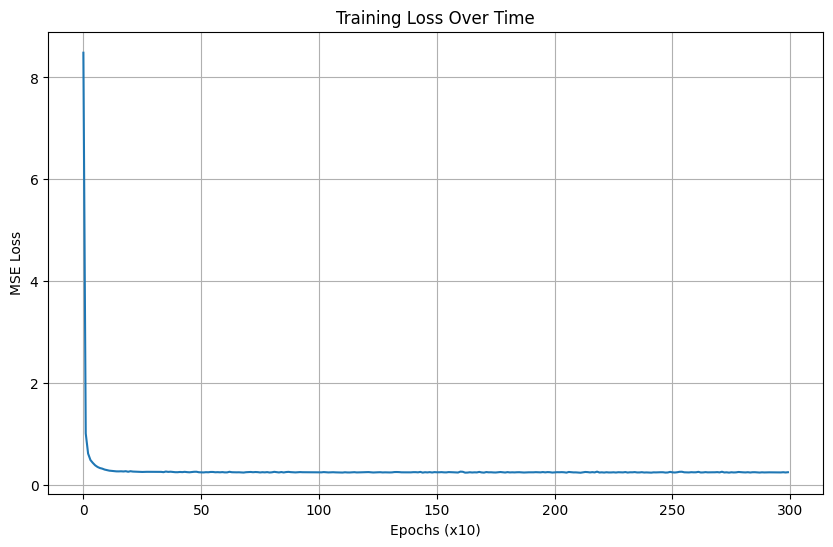

Test MSE Loss: 0.313943


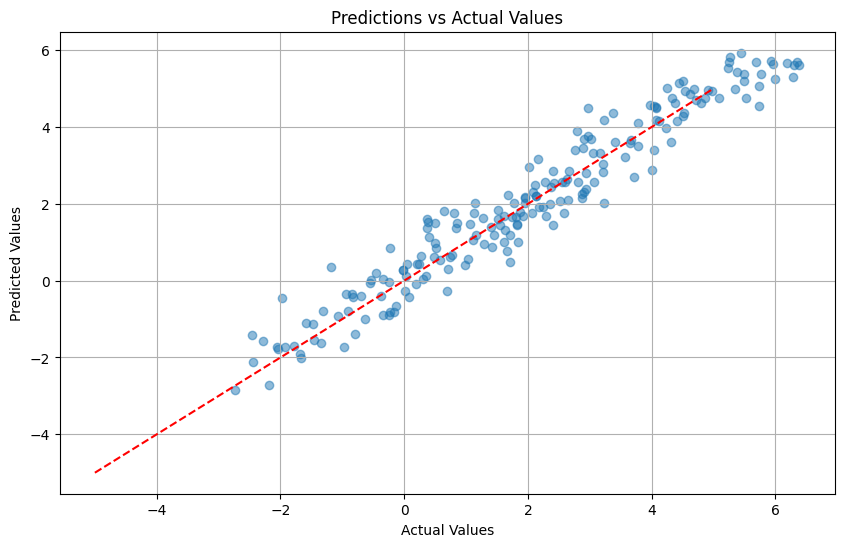

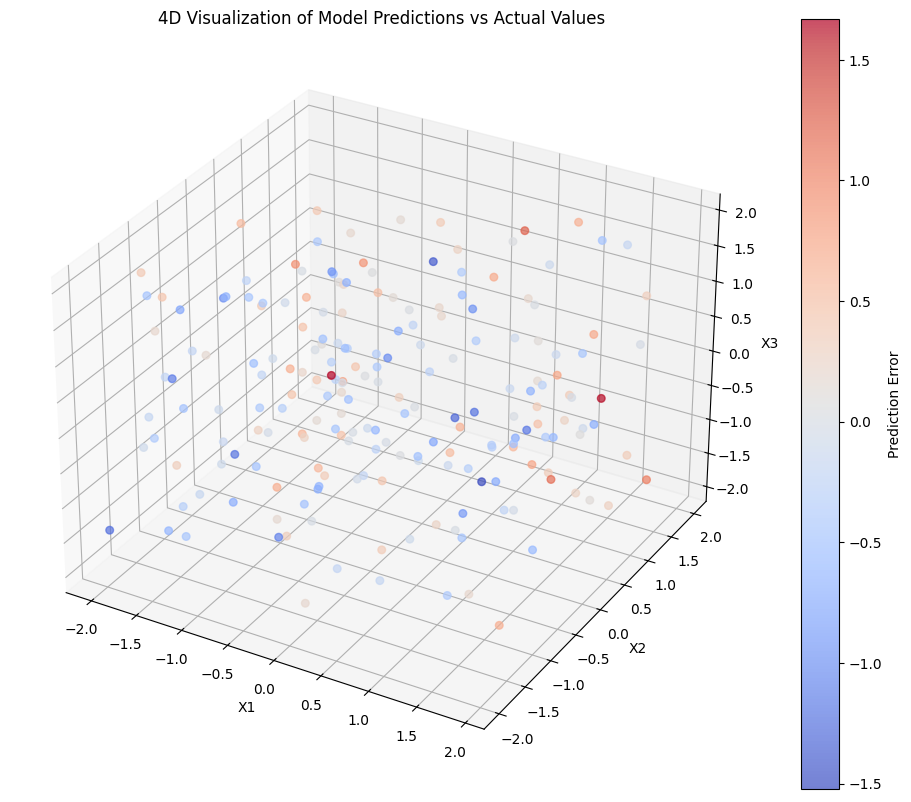

In [3]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epochs (x10)')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Evaluate on test set
y_pred_test = model(X_test)
test_loss = mse_loss(y_test, y_pred_test).numpy()
print(f"Test MSE Loss: {test_loss:.6f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred_test.numpy(), alpha=0.5)
plt.plot([-5, 5], [-5, 5], 'r--')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()

# Create a 4D visualization (3D plot with color as the 4th dimension)
def visualize_4d(X, y_true, y_pred, title):
    # Convert tensors to numpy
    X_np = X.numpy()
    y_true_np = y_true.numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    # Create a 3D scatter plot with color as the 4th dimension
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Calculate prediction error for coloring
    error = y_true_np - y_pred_np

    # Create the scatter plot
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=error,  # Use error for coloring
                          cmap=cm.coolwarm,
                          marker='o',
                          alpha=0.7,
                          s=30)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Prediction Error')

    # Set labels and title
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)

    # Show the plot
    plt.show()

# Generate sample data points for visualization
X_vis, y_vis = generate_data(200)

# Get predictions for visualization
y_vis_pred = model(X_vis)

# Create 4D visualization
visualize_4d(X_vis, y_vis, y_vis_pred, '4D Visualization of Model Predictions vs Actual Values')

## 2D Slice Visualization
To deepen our understanding of the model’s predictions across the input space, we’ll generate 2D slice visualizations.
By fixing one input variable and varying the other two, we can:

Observe how the model's output behaves across different combinations of features

Identify patterns or inconsistencies in the learned function

Gain a more intuitive grasp of the high-dimensional prediction surface

This technique helps make complex, multi-dimensional relationships more interpretable.

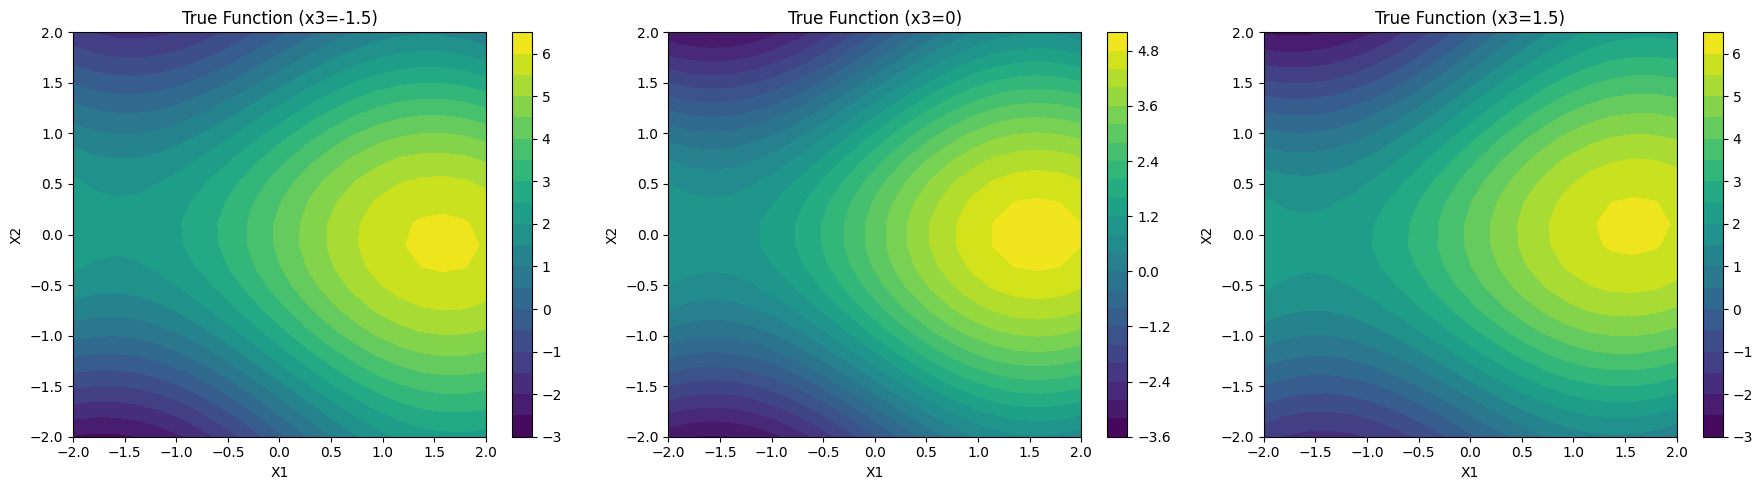

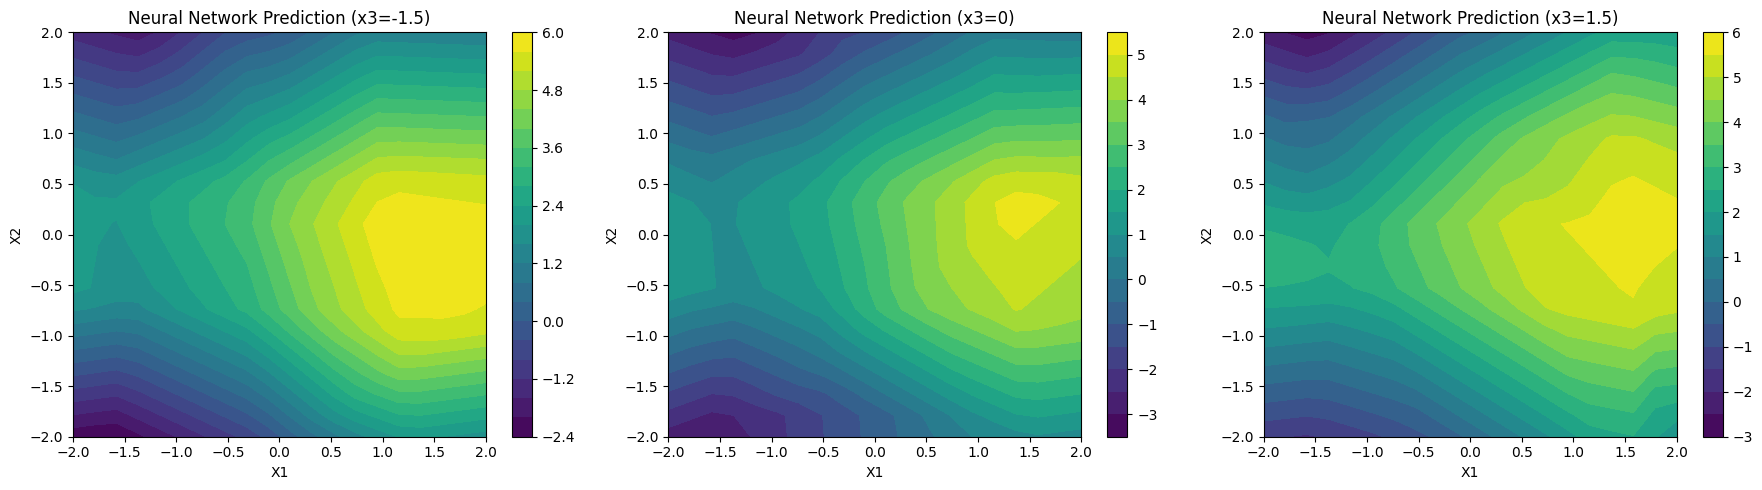

In [4]:
# Alternative visualization with 2D slices
def plot_2d_slices(X_range=2.0, grid_points=20):
    # Create a grid of points for visualization
    x1 = np.linspace(-X_range, X_range, grid_points)
    x2 = np.linspace(-X_range, X_range, grid_points)
    x3_values = [-1.5, 0, 1.5]  # Three fixed values for x3

    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input_np = np.zeros((grid_points*grid_points, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3

        # Convert to tensor
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)

        # Get true values and predictions
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        y_pred = model(X_input).numpy().reshape(grid_points, grid_points)

        # Plot the true function
        im1 = axes[i].contourf(X1, X2, y_true, cmap='viridis', levels=20)
        axes[i].set_title(f'True Function (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im1, ax=axes[i])

    plt.tight_layout()
    plt.show()

    # Now plot the predicted function
    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input_np = np.zeros((grid_points*grid_points, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3

        # Convert to tensor
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)

        # Get true values and predictions
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        y_pred = model(X_input).numpy().reshape(grid_points, grid_points)

        # Plot the predicted function
        im2 = axes[i].contourf(X1, X2, y_pred, cmap='viridis', levels=20)
        axes[i].set_title(f'Neural Network Prediction (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im2, ax=axes[i])

    plt.tight_layout()
    plt.show()

# Generate and plot 2D slices
plot_2d_slices(X_range=2.0, grid_points=20)